* [I. Introduction](#I)
    * [1.1 Generate standard HOSE Codes](#1.1)
    * [1.2 Generate Stereo-Enhanced HOSE Codes](#1.2)
* [II. HOSE-Based Nearest Neighbors Model](#II)
    * [2.1 Database Creation](#2.1)
    * [2.2 Prediction on the Validation dataset](#2.2)
        * [2.2.1. Generate HOSE codes for the Validation dataset](#2.2.1)
        * [2.2.2 Search the database and get prediction results](#2.2.2)
        * [2.2.3 Visualize Prediction Performance in the Validation Dataset](#2.2.3)
* [III. Compare prediction results using different model](#III)

# I. Introduction<a class="anchor" id="I"></a>
## 1.1 Generate standard HOSE Codes<a class="anchor" id="1.2"></a>
The HOSE code is hierarchical descriptors that encode information about the chemical environment around an atom.  It is built sphere-wise around the atom described;

In [1]:
# !pip install -e .
import sys
import os
import pandas as pd
from rdkit import Chem

RANDOM_STATE = 1

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# plot
import matplotlib.pyplot as plt

%matplotlib inline

src_path = os.path.join("..")
if src_path not in sys.path:
    sys.path.append(src_path)

src_path = os.path.join("..", "src")
if src_path not in sys.path:
    sys.path.append(src_path)

src_path = os.path.join("..", "external", "HOSE_code_generator")
if src_path not in sys.path:
    sys.path.append(src_path)

from src import (
    common,
    hose_code,
)  # Some common methods I defined


from hosegen import HoseGenerator
from hosegen.geometry import *

pd.set_option("display.max_rows", 10)
pd.set_option("display.max_columns", 100)

pd.options.mode.chained_assignment = None  # Suppress the SettingWithCopyWarning

The methods *get_Hose_codes* and *get_Hose_codes_from_file* can be used to generate a standard HOSE code.
Both need the index of the atom for which the HOSE code should be created as *atom_idx*. *max_radius* gives the number of spheres to use (default 5). *usestereo*, *wedgebond*, and *strict* are only used for the stereo-enhanced hose code (see below).

In [22]:
compound = Chem.MolFromSmiles("FC(C(F)(F)F)(F)C(O[H])=O")
gen = HoseGenerator()
gen.get_Hose_codes(compound, 0)

'F-1;C(CCF/=OO,FFF,/,,,,)/'

## 1.2 Generate Stereo-Enhanced HOSE Codes<a class="anchor" id="1.3"></a>
HOSE codes are generated for a specified atom in the molecule, considering stereochemistry and different neighborhood radii around that atom.

In [23]:
# Input SMILES with double bond
# smiles_input = "F/C([H])=C(Oc1ccc(CBr)cc1)/F"
smiles_input = 'FC(C(F)(F)F)(F)C(O[H])=O'
# Create a molecule object from the SMILES string
mol = Chem.MolFromSmiles(smiles_input)

# Generate the canonical SMILES while preserving stereochemistry
canonical_smiles = Chem.MolToSmiles(mol, isomericSmiles=True)

output_file_path = "Example.mol"
Chem.MolToMolFile(mol, output_file_path)

# A map of wedge bonds. Wedge bonds in chemistry are used to represent the 3D orientation of bonds
wedgemap = create_wedgemap(output_file_path)

# Initializes an instance of the HoseGenerator class
gen = HoseGenerator()

# Generate HOSE codes for atom 0 in the molecule
gen.get_Hose_codes(mol, 0, usestereo=True, max_radius=6, wedgebond=wedgemap)

'F-1;C(CCF/=OO,FFF,/,,,,)//'

In [31]:
gen.get_Hose_codes(mol, 4, usestereo=True, max_radius=0, wedgebond=wedgemap)

'F-1;(//)'

# II. HOSE-Based Nearest Neighbors Model<a class="anchor" id="II"></a>

The **HOSE-Based Nearest Neighbors Model** relies entirely on a database-driven search using HOSE codes. This approach demonstrates strong predictive performance when the training data contains highly similar molecules.

**Methodology:**

1. **Database Creation**: A HOSE Code-NMR shift database is constructed from the training dataset.
2. **Prediction**: For each atom in the validation/test dataset, the database is searched to find atoms with the same HOSE code. If multiple matches are found, the predicted shift is the average of their shifts.

HOSE codes can be generated with different radii. For a new atom, the search starts by looking for an exact match in the database with HOSE code generated with maximum radius (`max_radius`) of 6. If multiple matches are found, the average shift is returned and assigned a `similarity score` of 6. If no match is found, the search proceeds with HOSE code generated with `max_radius = 5`, and so on, until a match is found.

**Similarity Scoring:**

The similarity score for each prediction, which reflects the accuracy of the prediction to some extent, is based on the radius level of the HOSE code where a match is found
- **6**: Match found with `max_radius = 6`
- **5**: Match found with `max_radius = 5`
- **4**: Match found with `max_radius = 4` (HOSE codes with four or more spheres, including stereochemistry, are considered reliable)
- **3**: Match found with `max_radius = 3`
- **2**: Match found with `max_radius = 2`
- **1**: Match found with `max_radius = 1`



## 2.1 Database Creation<a class="anchor" id="2.1"></a>
A HOSE Code-NMR shift database is constructed from the training dataset.

In [5]:
#
# Get the train, validation, and test datasets
#
data_path = os.path.join("..", "dataset", "Processed_PFAS_19F_NMR_spectra_data.csv")
All_fluorinated_compounds = pd.read_csv(data_path)
train_dataset, test_fluorinated_compounds = common.split_datasets(All_fluorinated_compounds, RANDOM_STATE=RANDOM_STATE, verbose = True)

Number of fluorinated compounds in the train and test datasets are 549 and 98 respectively.
Ratio of PFAS in the train and test datasets are 0.61 and 1.00 respectively.


In [6]:
example = All_fluorinated_compounds[All_fluorinated_compounds["Compound name"] == "perfluoropropionic acid"]
example = hose_code.getHoseCodeContent(example)
example

,0,1,2,3,4,5,NMR_Peaks
4_COOH_1,F-1;C(//),F-1;C(CCF//),"F-1;C(CCF/=OO,FFF,/)","F-1;C(CCF/=OO,FFF,/,,,,)","F-1;C(CCF/=OO,FFF,/,,,,)/","F-1;C(CCF/=OO,FFF,/,,,,)//",-122.45
5_COOH_1,F-1;C(//),F-1;C(CCF//),"F-1;C(CCF/=OO,FFF,/)","F-1;C(CCF/=OO,FFF,/,,,,)","F-1;C(CCF/=OO,FFF,/,,,,)/","F-1;C(CCF/=OO,FFF,/,,,,)//",-122.45
7_COOH_1,F-1;C(//),F-1;C(CFF//),"F-1;C(CFF/CFF,,/)","F-1;C(CFF/CFF,,/=OO,,)","F-1;C(CFF/CFF,,/=OO,,),/","F-1;C(CFF/CFF,,/=OO,,),//",-83.4
8_COOH_1,F-1;C(//),F-1;C(CFF//),"F-1;C(CFF/CFF,,/)","F-1;C(CFF/CFF,,/=OO,,)","F-1;C(CFF/CFF,,/=OO,,),/","F-1;C(CFF/CFF,,/=OO,,),//",-83.4
9_COOH_1,F-1;C(//),F-1;C(CFF//),"F-1;C(CFF/CFF,,/)","F-1;C(CFF/CFF,,/=OO,,)","F-1;C(CFF/CFF,,/=OO,,),/","F-1;C(CFF/CFF,,/=OO,,),//",-83.4


In [7]:
random_seeds = [42, 30, 512, 76, 61]

def test_HOSE_model_performance(dataset, random_seeds):
    '''
    Splite the dataset into training and validation sets;
    Use the training set to build HOSE code database, which will be used to predict the NMR chemical shifts of fluorinated compounds in the validation set.
    Get the performance of the mode on the validatiaon dataset.
    '''
    vali_results = {}
    vali_results_tables = pd.DataFrame()
    HOSE_code_train_tables = pd.DataFrame()
    HOSE_code_vali_tables = pd.DataFrame()
    for random_seed in random_seeds:
        print(f"\n>>>>> Random seed: {random_seed} <<<<<")
        train_fluorinated_compounds, vali_fluorinated_compounds = common.split_datasets(
            dataset, RANDOM_STATE=random_seed
        )
        # Data processing and get HOSE databse using the training set
        HOSE_Code_database = hose_code.getHoseCodeContent(train_fluorinated_compounds)
        HOSE_code_train_tables = pd.concat([HOSE_code_train_tables, HOSE_Code_database], axis=0)

        # Get HOSE Code and corresponding 19F NMR values using train dataset
        sphere_dics = hose_code.getTrainDictionary_HOSE(HOSE_Code_database)
        HOSE_Code_database["NMR_Peaks"] = HOSE_Code_database["NMR_Peaks"].astype(float)

        HOSE_codes_vali = hose_code.getHoseCodeContent(vali_fluorinated_compounds)
        HOSE_code_vali_tables = pd.concat([HOSE_code_vali_tables, HOSE_codes_vali], axis=0)

        # Get prediction results and corresponding similarity levels for the validation dataset
        prediction, similarity_levels = hose_code.HOSE_Model(
            sphere_dics, test_data = HOSE_codes_vali, mean_value_in_train_data = HOSE_Code_database["NMR_Peaks"].mean()
        )

        # Validation dataset
        vali_results_table = hose_code.getResults_HOSE(prediction, similarity_levels, HOSE_codes_vali)

        vali_results_table = vali_results_table.dropna(subset = ['actual'])

        vali_mae = mean_absolute_error(vali_results_table['actual'], vali_results_table['prediction'])
        vali_mse = mean_squared_error(vali_results_table['actual'], vali_results_table['prediction'])
        vali_rmse = np.sqrt(vali_mse)
        vali_r2 = r2_score(vali_results_table['actual'], vali_results_table['prediction'])
        vali_results[f'random_seed = {random_seed}'] = {'mae': vali_mae, 'rmse': vali_rmse, 'r2': vali_r2}

        vali_results_tables = pd.concat([vali_results_tables, vali_results_table], axis=0)

    vali_results_df = pd.DataFrame(vali_results).T

    print('--------Validation results DataFrame--------')
    display(vali_results_df)
    return HOSE_code_train_tables, HOSE_code_vali_tables, vali_results_tables, vali_results_df

In [8]:
random_seeds = [42, 30, 512, 76, 61]

HOSE_code_train_tables, HOSE_code_vali_tables, vali_results_tables, vali_results_df = test_HOSE_model_performance(train_dataset, random_seeds)


>>>>> Random seed: 42 <<<<<


[17:27:08] UFFTYPER: Warning: hybridization set to SP3 for atom 6



>>>>> Random seed: 30 <<<<<


[17:27:11] UFFTYPER: Warning: hybridization set to SP3 for atom 6



>>>>> Random seed: 512 <<<<<


[17:27:18] UFFTYPER: Warning: hybridization set to SP3 for atom 6



>>>>> Random seed: 76 <<<<<


[17:27:26] UFFTYPER: Warning: hybridization set to SP3 for atom 6



>>>>> Random seed: 61 <<<<<


[17:27:29] UFFTYPER: Warning: hybridization set to SP3 for atom 6


--------Validation results DataFrame--------


,mae,rmse,r2
random_seed = 42,2.622218,8.699903,0.897290
random_seed = 30,2.746972,7.097844,0.936098
random_seed = 512,3.152317,9.455695,0.873816
random_seed = 76,3.642379,10.691325,0.849346
random_seed = 61,2.314612,5.908732,0.951176


In [9]:
HOSE_code_train_tables.to_csv(os.path.join("..", "artifacts", "results", "HOSE_code_train_tables_with_5_random_seeds.csv"), index=True)
HOSE_code_vali_tables.to_csv(os.path.join("..", "artifacts", "results", "HOSE_code_vali_tables_with_5_random_seeds.csv"), index=True)

In [10]:
def show_HOSE_model_perfromance_on_vali(vali_results_tables, vali_results_df, model_info = ''):
    """
    Show the performance of the model on the validation datasets.

    These information help to evaluate the model's performance and generalization ability, identify potential overfitting or underfitting issues.
    
    Args:
        vali_results_tables: DataFrame with results of the model on validation dataset.
        vali_results_df: DataFrame with performance metrics on validation dataset.
        model_info: String with information about the model.
    """
    print(f'\n>>>>> Model information: {model_info} <<<<<\n')
    print('\nPerformance of model on validation dataset')
    print(f'mae: {vali_results_df["mae"].mean():.2f} ± {vali_results_df["mae"].std():.2f}')
    print(f'rmse: {vali_results_df["rmse"].mean():.2f} ± {vali_results_df["rmse"].std():.2f}')
    print(f'r2: {vali_results_df["r2"].mean():.2f} ± {vali_results_df["r2"].std():.2f}')

    print('\n--------Validation results plot--------')
    common.plot_prediction_performance(vali_results_tables)
    print('\n--------Validation results scatter plot--------')
    common.show_results_scatter(vali_results_tables)


>>>>> Model information: HOSE code model <<<<<


Performance of model on validation dataset
mae: 2.90 ± 0.51
rmse: 8.37 ± 1.89
r2: 0.90 ± 0.04

--------Validation results plot--------


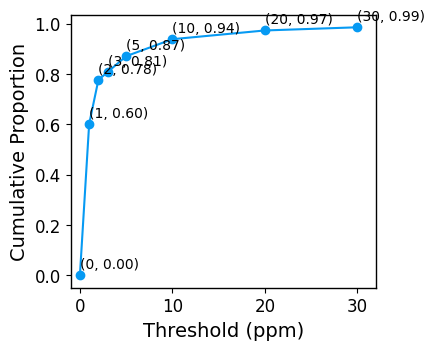


--------Validation results scatter plot--------
R2 = 0.90
RMSE = 8.41
MAE = 2.8562228043658853


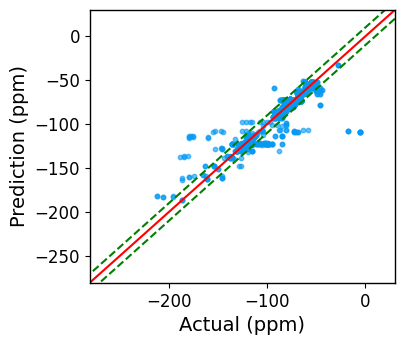

In [11]:
show_HOSE_model_perfromance_on_vali(vali_results_tables, vali_results_df, model_info = 'HOSE code model')

In [12]:
vali_results_tables.head()

,actual,prediction,diff,similarity_levels
4_COOH_29,-120.1,-119.621538,0.478462,6
5_COOH_29,-120.1,-119.621538,0.478462,6
7_COOH_29,-122.8,-122.301818,0.498182,6
8_COOH_29,-122.8,-122.301818,0.498182,6
10_COOH_29,-122.8,-122.325000,0.475000,6


In [13]:
vali_results_df.head()

,mae,rmse,r2
random_seed = 42,2.622218,8.699903,0.897290
random_seed = 30,2.746972,7.097844,0.936098
random_seed = 512,3.152317,9.455695,0.873816
random_seed = 76,3.642379,10.691325,0.849346
random_seed = 61,2.314612,5.908732,0.951176


In [33]:
vali_results_df.describe()

,mae,rmse,r2
count,5.000000,5.000000,5.000000
mean,2.895699,8.370700,0.901545
std,0.514286,1.894224,0.042335
min,2.314612,5.908732,0.849346
25%,2.622218,7.097844,0.873816
50%,2.746972,8.699903,0.897290
75%,3.152317,9.455695,0.936098
max,3.642379,10.691325,0.951176


## 2.2 Prediction on the Validation dataset<a class="anchor" id="2.2"></a>
## 2.2.1. Generate HOSE codes for the Validation dataset<a class="anchor" id="2.2.1"></a>

## 2.2.2 Search the database and get prediction results<a class="anchor" id="2.2.2"></a>

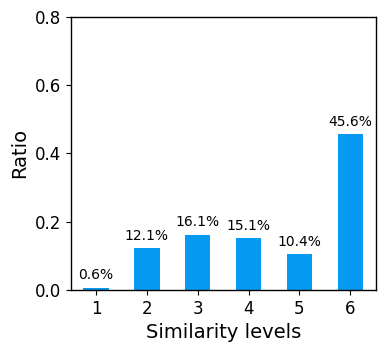

In [14]:
# Plot the distribution of data points across different similarity levels
# Sort the value counts by the index (the similarity levels)
results = vali_results_tables.copy()

# results['similarity_levels'] = results['similarity_levels'].apply(lambda x:x if x < 4 else 4)

sorted_counts = results["similarity_levels"].value_counts(normalize=True).sort_index()

cm = 1 / 2.54  # centimeters in inches
fig, ax = plt.subplots(figsize=(10 * cm, 9 * cm))  # 8 cm x 8 cm

# Plotting the sorted value counts
ax = sorted_counts.plot(kind="bar", color="#069AF3")

# Adding the percentage labels above each bar
for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.1%}",  # Format the height as a percentage
        (
            p.get_x() + p.get_width() / 2.0,
            p.get_height(),
        ),  # Position for the annotation
        ha="center",  # Horizontal alignment: center
        va="center",  # Vertical alignment: center
        xytext=(0, 9),  # Offset the text by 9 points above the bar
        textcoords="offset points",  # Use offset points to position the text
    )

# Set border (edge) line width
ax.spines["top"].set_linewidth(1)  # Top border
ax.spines["right"].set_linewidth(1)  # Right border
ax.spines["bottom"].set_linewidth(1)  # Bottom border
ax.spines["left"].set_linewidth(1)  # Left border

# Set axis titles and tick label font sizes
ax.set_xlabel("Similarity levels", fontsize=14)  # Replace with your label
ax.set_ylabel("Ratio", fontsize=14)  # Replace with your label
ax.tick_params(axis="x", labelsize=12)  # X-axis numbers font size
ax.tick_params(axis="y", labelsize=12)  # Y-axis numbers font size

ax.set_ylim([0, 0.8])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8])  # Set x-axis labels to be more readable
# Set the x-axis labels in the correct order
ax.set_xticklabels(sorted_counts.index)
ax.tick_params(axis="x", rotation=0)

plt.show()

The distribution of data points in the validation dataset across different similarity levels

## 2.2.3 Visualize Prediction Performance in the Validation Dataset<a class="anchor" id="2.2.3"></a>

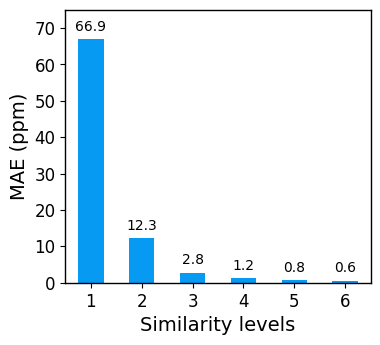

In [15]:
# Create the figure and axes with specified size
cm = 1 / 2.54  # centimeters in inches
fig, ax = plt.subplots(figsize=(10 * cm, 9 * cm))  # 8 cm x 8 cm
ax = (
    results.groupby("similarity_levels")["diff"]
    .mean()
    .plot(kind="bar", color="#069AF3")
)

# Add the height (mean value) above each bar
for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.1f}",  # Format the height to two decimal places
        (
            p.get_x() + p.get_width() / 2.0,
            p.get_height(),
        ),  # Position for the annotation
        ha="center",  # Horizontal alignment: center
        va="center",  # Vertical alignment: center
        xytext=(0, 9),  # Offset the text by 9 points above the bar
        textcoords="offset points",  # Use offset points to position the text
    )

ax.tick_params(axis="x", rotation=0)

# Set border (edge) line width
ax.spines["top"].set_linewidth(1)  # Top border
ax.spines["right"].set_linewidth(1)  # Right border
ax.spines["bottom"].set_linewidth(1)  # Bottom border
ax.spines["left"].set_linewidth(1)  # Left border

# Set axis titles and tick label font sizes
ax.set_xlabel("Similarity levels", fontsize=14)  # Replace with your label
ax.set_ylabel("MAE (ppm)", fontsize=14)  # Replace with your label
ax.tick_params(axis="x", labelsize=12)  # X-axis numbers font size
ax.tick_params(axis="y", labelsize=12)  # Y-axis numbers font size

ax.set_ylim([0, 75])

plt.show()

Prediction performance of the HOSE-Based Nearest Neighbors Model on the validation dataset

In [16]:
file_path = os.path.join(
    "..", "artifacts", "results", "HOSE Results On Validation Dataset with 5 Random Seeds.csv"
)

results.to_csv(file_path, encoding="utf-8", index=True)